In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import numpy as np
import os
from time import time

import ML
ML.showAllVariables()
ML.init()
Sess = ML.limitGPUByGrowth()

E:\Program\Anaconda3\envs\tensorflow\lib\importlib\_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
E:\Program\Anaconda3\envs\tensorflow\lib\importlib\_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
E:\Program\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


/device:CPU:0
/device:GPU:0
Start using first GPU


Extracting E:/WorkSpace/TensorFlowWorkSpace/running_data/download_data/MNIST_data\train-images-idx3-ubyte.gz
Extracting E:/WorkSpace/TensorFlowWorkSpace/running_data/download_data/MNIST_data\train-labels-idx1-ubyte.gz
Extracting E:/WorkSpace/TensorFlowWorkSpace/running_data/download_data/MNIST_data\t10k-images-idx3-ubyte.gz
Extracting E:/WorkSpace/TensorFlowWorkSpace/running_data/download_data/MNIST_data\t10k-labels-idx1-ubyte.gz

train images:  (55000, 784) 
labels (55000, 10) 

validation images:  (5000, 784) 
labels (5000, 10) 

test images:  (10000, 784) 
labels (10000, 10) 



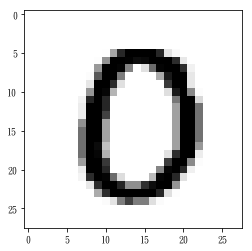

0

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("E:/WorkSpace/TensorFlowWorkSpace/running_data/download_data/MNIST_data",
                                  one_hot=True)

print('\ntrain images: ',mnist.train.images.shape,'\n'
     'labels',mnist.train.labels.shape,'\n')
print('validation images: ',mnist.validation.images.shape,'\n'
     'labels',mnist.validation.labels.shape,'\n')
print('test images: ',mnist.test.images.shape,'\n'
     'labels',mnist.test.labels.shape,'\n')

def plot_image(image):
    plt.imshow(image.reshape(28,28),cmap='binary')
    plt.show()   
    
plot_image(mnist.train.images[10])
np.argmax(mnist.train.labels[10]) #numpy.argmax : 回傳該維度最大值所在的index

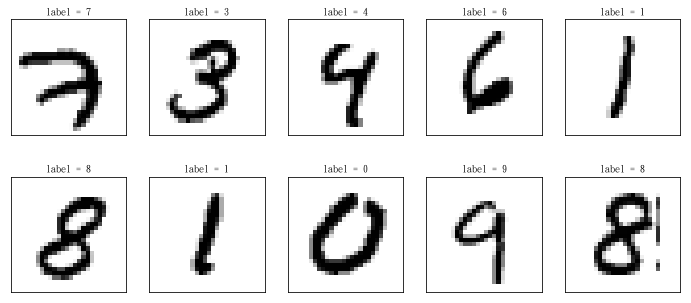

validation images (5000, 784)
validation labels (5000, 10)


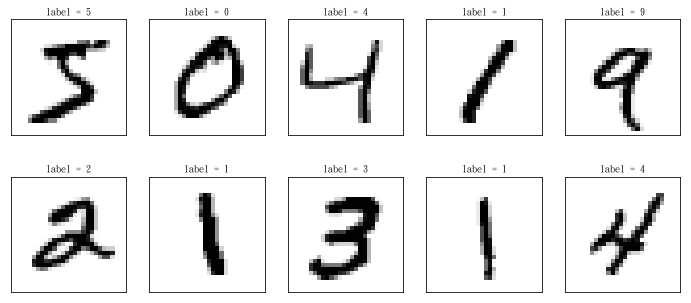

test images (10000, 784)
test labels (10000, 10)


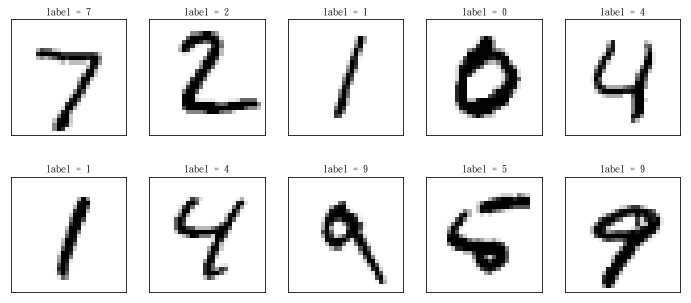

In [3]:
def plot_images_labels_prediction(images,labels,prediction,idx,num=10):
    fig = plt.gcf()
    fig.set_size_inches(12,14)
    if num>25 : num=25
    for i in range(0,num):
        ax = plt.subplot(5,5,i+1)
        ax.imshow(np.reshape(images[idx],(28,28)),cmap='binary')
        title = "label = " + str(np.argmax(labels[idx]))
        if len(prediction)>0:
            title += ", prediction = " + str(prediction[idx])
        ax.set_title(title,fontsize=10)
        ax.set_xticks([]); ax.set_yticks([])
        idx+=1
    plt.show()
    
#預查training資料
plot_images_labels_prediction(mnist.train.images,
                              mnist.train.labels,
                              [],0)
#預查validation資料
print('validation images',mnist.validation.images.shape)
print('validation labels',mnist.validation.labels.shape)
plot_images_labels_prediction(mnist.validation.images,
                              mnist.validation.labels,
                              [],0)
#預查test資料
print('test images',mnist.test.images.shape)
print('test labels',mnist.test.labels.shape)
plot_images_labels_prediction(mnist.test.images,
                              mnist.test.labels,
                              [],0)

In [4]:
#模型函數定義
def layer(input_dim,output_dim,inputs,activation):
    W = tf.Variable(tf.random_normal([input_dim,output_dim])) 
    b = tf.Variable(tf.random_normal([1,output_dim]))
    outputs = tf.matmul(inputs,W) + b 
    if activation ==None:
        return outputs
    else: 
        return activation(outputs)
#MLP model架構
x = tf.placeholder(tf.float32,[None,784])    
h1 = layer(input_dim=784,
           output_dim=1000, # output_dim 改為1000
           inputs=x,
           activation=tf.nn.relu)
h2 = layer(input_dim=1000,
           output_dim=1000, # output_dim 改為1000
           inputs=h1,
           activation=tf.nn.relu)
y_predict = layer(input_dim=1000, # y_predict : 每次epoch的預測值
          output_dim=10,
          inputs=h2,
          activation=None)
y_label = tf.placeholder(tf.float32,[None,10]) # y_predict : 每次epoch的真實label

#定義loss function
loss_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_predict,
                                                                       labels=y_label))
#定義Optimizer function
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss_function)

#定義模型預測
prediction = tf.equal(tf.argmax(y_predict,1),
                              tf.argmax(y_label,1))

#定義模型準確率
accuracy = tf.reduce_mean(tf.cast(prediction,tf.float32))

In [5]:
#定義訓練參數
trainEpochs = 15
batchSize = 100
totalBatch =int(mnist.train.num_examples / batchSize)
loss_list = [];  epoch_list = []; accuracy_list= []

startime = time()
with Sess as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    for epoch in range(trainEpochs):
        for i in range(totalBatch):
            batch_x,batch_y = mnist.train.next_batch(batchSize)
            sess.run(optimizer,feed_dict={x:batch_x,y_label:batch_y}) # batch_x:影像特徵值 ,batch_y:影像真實值
            loss,acc = sess.run([loss_function,accuracy],feed_dict={x:mnist.validation.images,
                                                                    y_label:mnist.validation.labels})
        epoch_list.append(epoch)
        loss_list.append(loss)
        accuracy_list.append(acc)
        print("Train Epoch:" , '%02d'%(epoch+1), ", Loss =",'%.9f'% loss,", Accuracy=",acc)
    duration = time() - startime

    print("Train Finished cost " , duration)
    print("Accuracy:",sess.run(accuracy,feed_dict={x:mnist.test.images,
                                                   y_label:mnist.test.labels}))
    prediction_result = sess.run(tf.argmax(y_predict,1),feed_dict={x:mnist.test.images})
    

Train Epoch: 01 , Loss = 130.359130859 , Accuracy= 0.9188
Train Epoch: 02 , Loss = 90.676177979 , Accuracy= 0.9302
Train Epoch: 03 , Loss = 75.255722046 , Accuracy= 0.9428
Train Epoch: 04 , Loss = 60.586006165 , Accuracy= 0.9512
Train Epoch: 05 , Loss = 60.371780396 , Accuracy= 0.9496
Train Epoch: 06 , Loss = 57.876194000 , Accuracy= 0.9514
Train Epoch: 07 , Loss = 48.466217041 , Accuracy= 0.9582
Train Epoch: 08 , Loss = 65.091094971 , Accuracy= 0.9494
Train Epoch: 09 , Loss = 50.332283020 , Accuracy= 0.9572
Train Epoch: 10 , Loss = 49.356456757 , Accuracy= 0.96
Train Epoch: 11 , Loss = 47.053916931 , Accuracy= 0.9654
Train Epoch: 12 , Loss = 59.420867920 , Accuracy= 0.9618
Train Epoch: 13 , Loss = 50.865917206 , Accuracy= 0.9654
Train Epoch: 14 , Loss = 50.249336243 , Accuracy= 0.9658
Train Epoch: 15 , Loss = 47.327644348 , Accuracy= 0.9648
Train Finished cost  143.3296353816986
Accuracy: 0.9657


<Figure size 432x288 with 0 Axes>

Text(0.5,1,'誤差值趨勢圖')

Text(0.5,0,'epoch')

Text(0,0.5,'loss')

(0, 15)

Text(0.5,1,'準確率趨勢圖')

Text(0.5,0,'epoch')

Text(0,0.5,'accuracy')

(0, 15)

(0.8, 1)

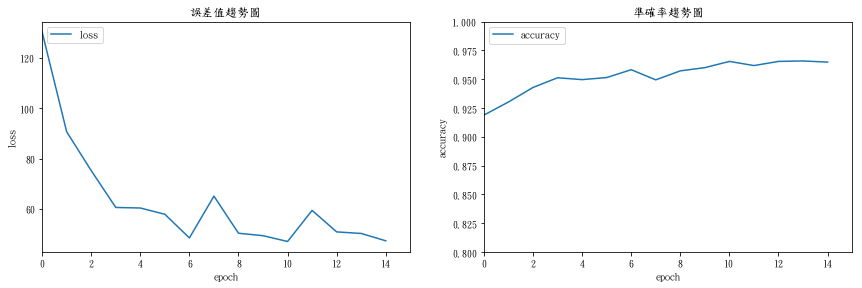

In [6]:
# loss_list
%matplotlib inline

left = 0.125 # the left side of the subplots of the figure
right = 2 # the right side of the subplots of the figure
bottom = 0.1 # the bottom of the subplots of the figure
top = 0.9 # the top of the subplots of the figure
wspace = 0.2 # the amount of width reserved for blank space between subplots
hspace = 0.5 # the amount of height reserved for white space between subplots

plt.subplots_adjust(left, bottom, right, top, wspace, hspace)


plt.figure(1)
plt.subplot(121)
# fig.set_size_inches(4,2)
plt.plot(epoch_list,loss_list,label='loss')
plt.title('誤差值趨勢圖')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.xlim(0,15)
plt.legend(['loss'],loc='upper left')


plt.subplot(122)
plt.plot(epoch_list,accuracy_list,label='accuracy')
plt.title('準確率趨勢圖')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.xlim(0,15)
plt.ylim(0.8,1) #設定Y軸顯示的範圍
plt.legend(['accuracy'],loc='upper left')




array([7, 2, 1, 0, 4, 1, 4, 9, 6, 9], dtype=int64)

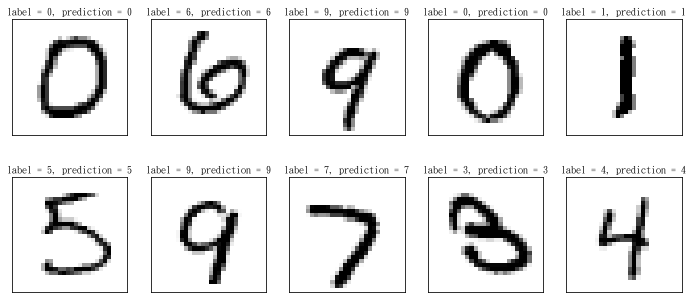

In [7]:
prediction_result[:10]
plot_images_labels_prediction(mnist.test.images,mnist.test.labels,prediction_result,10)

In [8]:
pd.crosstab(np.argmax(mnist.test.labels,1),
            prediction_result,
            rownames=['label'],
            colnames=['predict'])


predict,0,1,2,3,4,5,6,7,8,9
label,,,,,,,,,,
0,973,1,1,0,0,1,0,0,2,2
1,0,1123,2,2,0,0,3,2,3,0
2,7,0,1007,5,3,0,1,2,6,1
3,0,0,13,979,1,5,0,3,6,3
4,1,1,7,0,957,0,2,0,0,14
5,8,0,2,11,2,851,6,1,6,5
6,10,2,0,2,8,9,925,0,2,0
7,2,4,16,10,9,1,0,953,4,29
8,14,1,6,11,3,5,5,4,918,7


,label,predict
340,5,3
1082,5,3
1393,5,3
2369,5,3
2597,5,3
3902,5,3
3952,5,3
5982,5,3
8160,5,3
9482,5,3


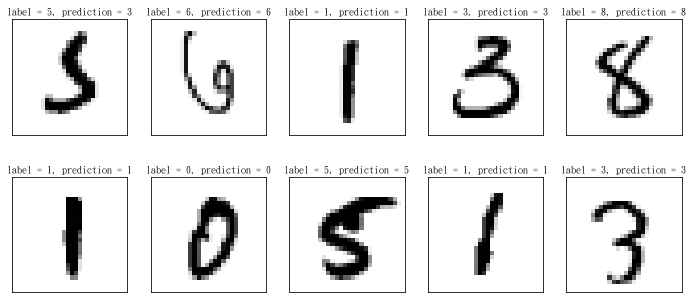

In [9]:
df = pd.DataFrame({'label':np.argmax(mnist.test.labels,1),'predict':prediction_result})
df[(df.label==5)&(df.predict==3)]
plot_images_labels_prediction(mnist.test.images,mnist.test.labels,prediction_result,idx=340)